In [1]:
pip install --upgrade google-cloud-discoveryengine humanize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.1 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import humanize
import time
import re
from typing import List, Optional

from google.api_core.client_options import ClientOptions
from google.cloud import discoveryengine_v1beta as discoveryengine


def _call_list_documents(
    project_id: str, location: str, datastore_id: str, page_token: Optional[str] = None
) -> discoveryengine.ListDocumentsResponse:
    """Build the List Docs Request payload."""
    client_options = (
        ClientOptions(
            api_endpoint=f"{location}-discoveryengine.googleapis.com")
        if location != "global"
        else None
    )
    client = discoveryengine.DocumentServiceClient(
        client_options=client_options)

    request = discoveryengine.ListDocumentsRequest(
        parent=client.branch_path(
            project_id, location, datastore_id, "default_branch"
        ),
        page_size=1000,
        page_token=page_token,
    )

    return client.list_documents(request=request)


def list_documents(
    project_id: str, location: str, datastore_id: str, rate_limit: int = 1
) -> List[discoveryengine.Document]:
    """Gets a list of docs in a datastore."""

    res = _call_list_documents(project_id, location, datastore_id)

    # setup the list with the first batch of docs
    docs = res.documents

    while res.next_page_token:
        # implement a rate_limit to prevent quota exhaustion
        time.sleep(rate_limit)

        res = _call_list_documents(
            project_id, location, datastore_id, res.next_page_token
        )
        docs.extend(res.documents)

    return docs


def list_indexed_urls(
    docs: Optional[List[discoveryengine.Document]] = None,
    project_id: str = None,
    location: str = None,
    datastore_id: str = None,
) -> List[str]:
    """Get the list of docs in data store, then parse to only urls."""
    if not docs:
        docs = list_documents(project_id, location, datastore_id)
    urls = [doc.content.uri for doc in docs]

    return urls


def search_url(urls: List[str], url: str) -> None:
    """Searches a url in a list of urls."""
    for item in urls:
        if url in item:
            print(item)


def search_doc_id(
    doc_id: str,
    docs: Optional[List[discoveryengine.Document]] = None,
    project_id: str = None,
    location: str = None,
    datastore_id: str = None,
) -> None:
    """Searches a doc_id in a list of docs."""
    if not docs:
        docs = list_documents(project_id, location, datastore_id)

    doc_found = False
    for doc in docs:
        if doc.parent_document_id == doc_id:
            doc_found = True
            print(doc)

    if not doc_found:
        print(f"Document not found for provided Doc ID: `{doc_id}`")


def estimate_data_store_size(
    urls: Optional[List[str]] = None,
    docs: Optional[List[discoveryengine.Document]] = None,
    project_id: str = None,
    location: str = None,
    datastore_id: str = None,
) -> None:
    """For Advanced Website Indexing data stores only."""
    if not urls:
        if not docs:
            docs = list_documents(project_id, location, datastore_id)
        urls = list_indexed_urls(docs=docs)

    # Filter to only include website urls.
    urls = list(filter(lambda x: re.search(r"https?://", x), urls))

    if not urls:
        print(
            "No urls found. Make sure this data store is for websites with advanced indexing."
        )
        return

    # For website indexing, each page is calculated as 500KB.
    size = len(urls) * 500_000
    print(f"Estimated data store size: {humanize.naturalsize(size)}")


PENDING_MESSAGE = """
No docs found.\n\nIt\'s likely one of the following issues: \n  [1] Your data store is not finished indexing. \n  [2] Your data store failed indexing. \n  [3] Your data store is for website data without advanced indexing.\n\n
If you just added your data store, it can take up to 4 hours before it will become available.
"""

## Creating a new data store.

Navigate to Agent Builder console and click on CONTINUE AND ACTIVATE THE API button.

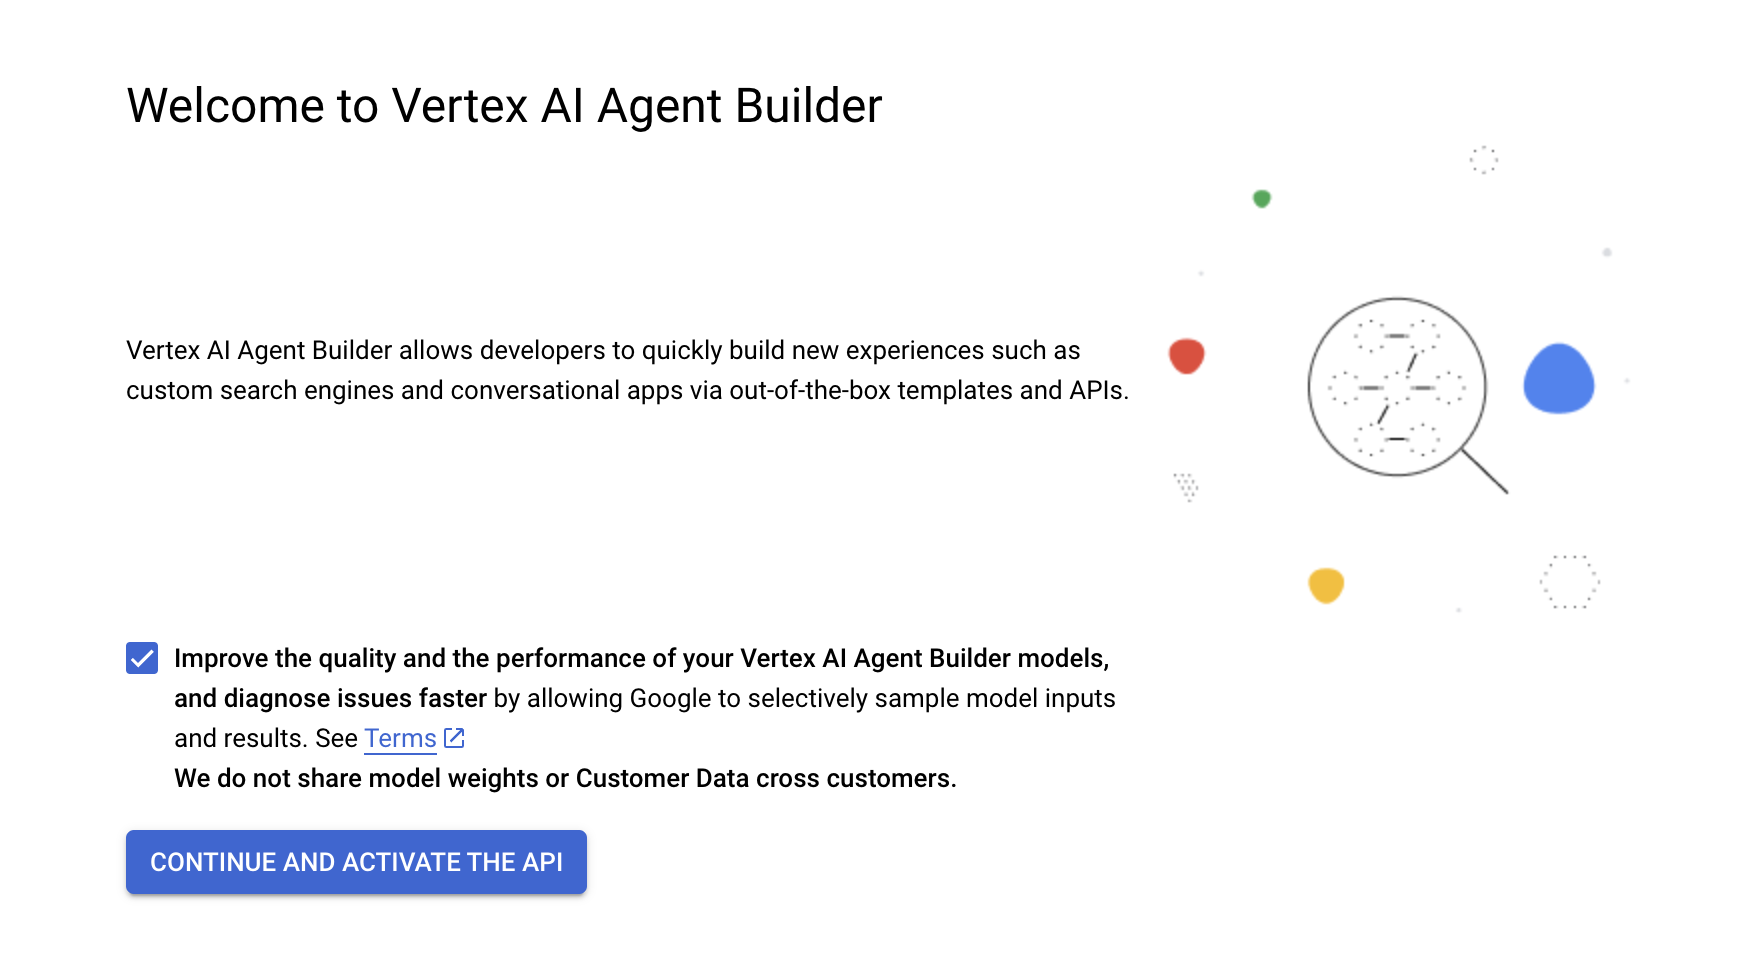

In the Create App page, select Chat as an App type.

For Company Name enter Cymbal. For Agent Name enter cymbalagent and click CONTINUE.

In the Data Stores page, click + CREATE NEW DATA STORE.

Select Cloud Storage, and enter the following Google Cloud Storage location cloud-samples-data/dialogflow-cx/arc-lifeblood to add the folder. Then select Unstructured documents under What kind of data are you importing? section and finally click CONTINUE.

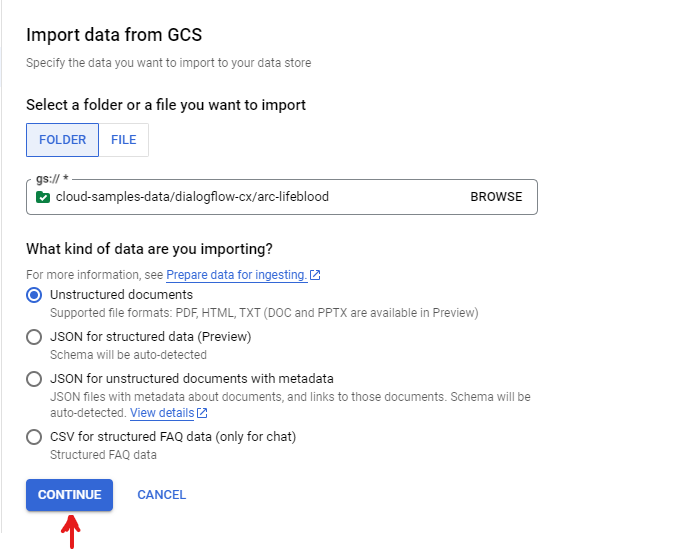

import data

For Data store name, enter cymbaldatastore and click CREATE. This creates a Data store.

Finally on the App's Data page, select cymbaldatastore and click on CREATE.

Click on cymbaldatastore and note down the Data store ID.

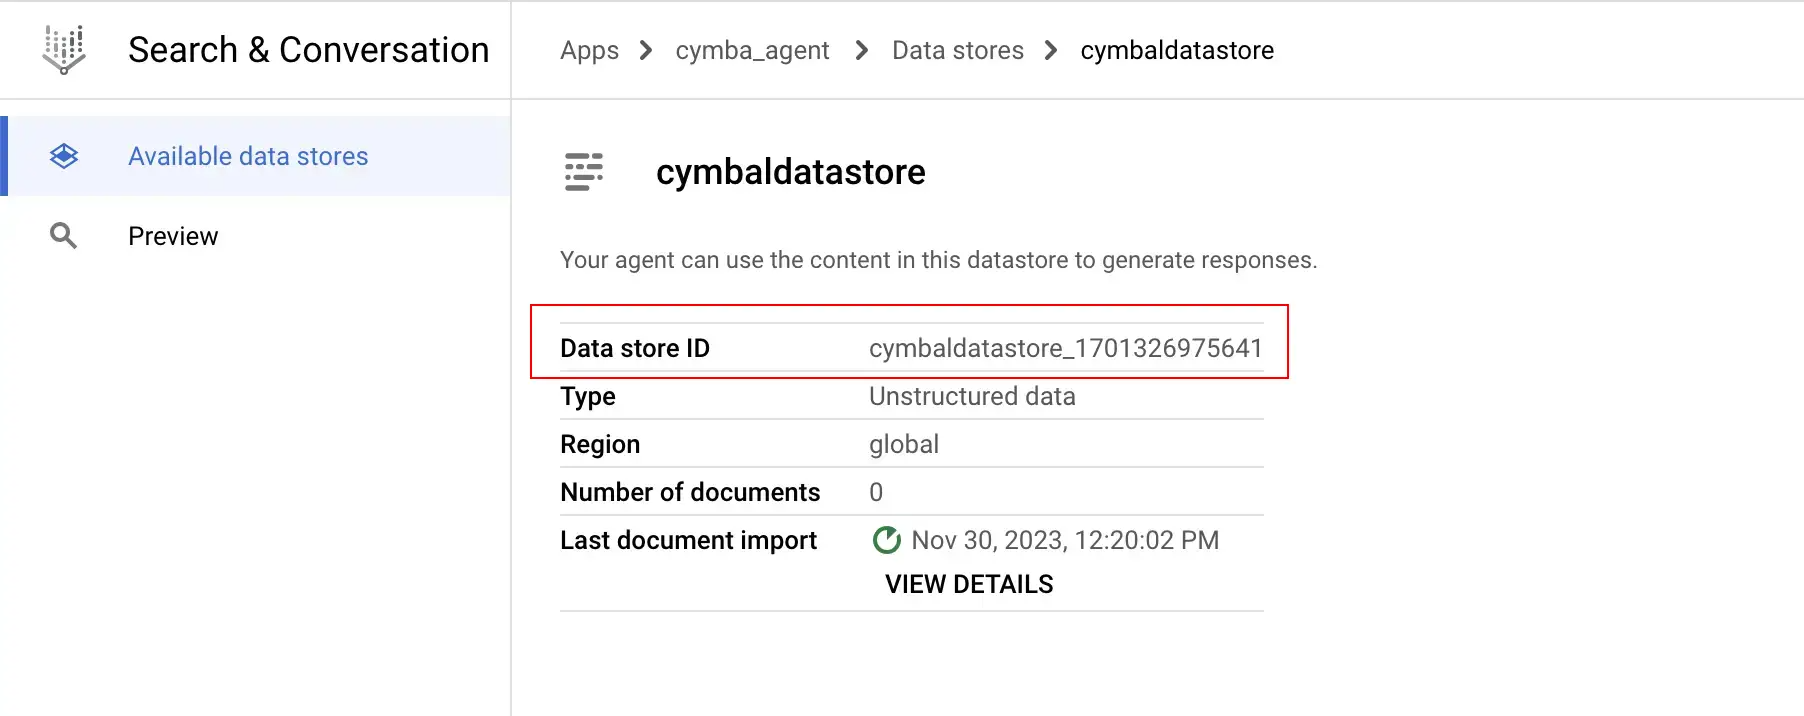

Data Store ID

Alternatively, you can find the datastore_id by from Navigation Menu navigation-menu > Agent Builder.

For cymbalagent, click on View under Connected data stores.

datastore View

Finally, click on cymbaldatastore to view the Data store ID. Note down the Data store ID.
Available Data Store 

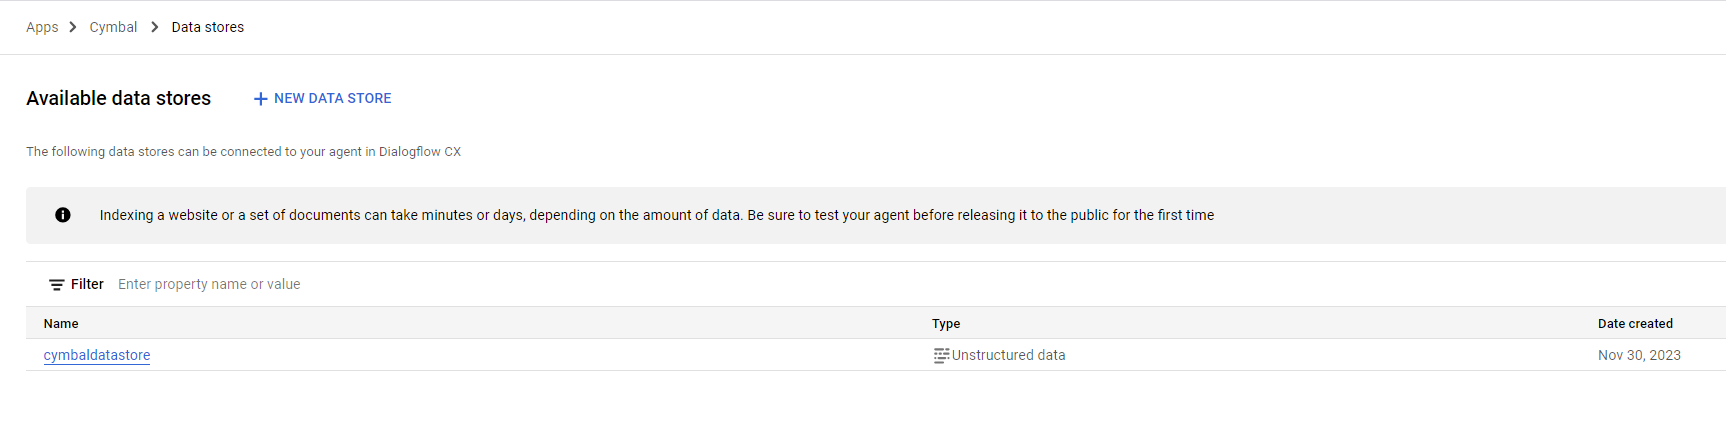

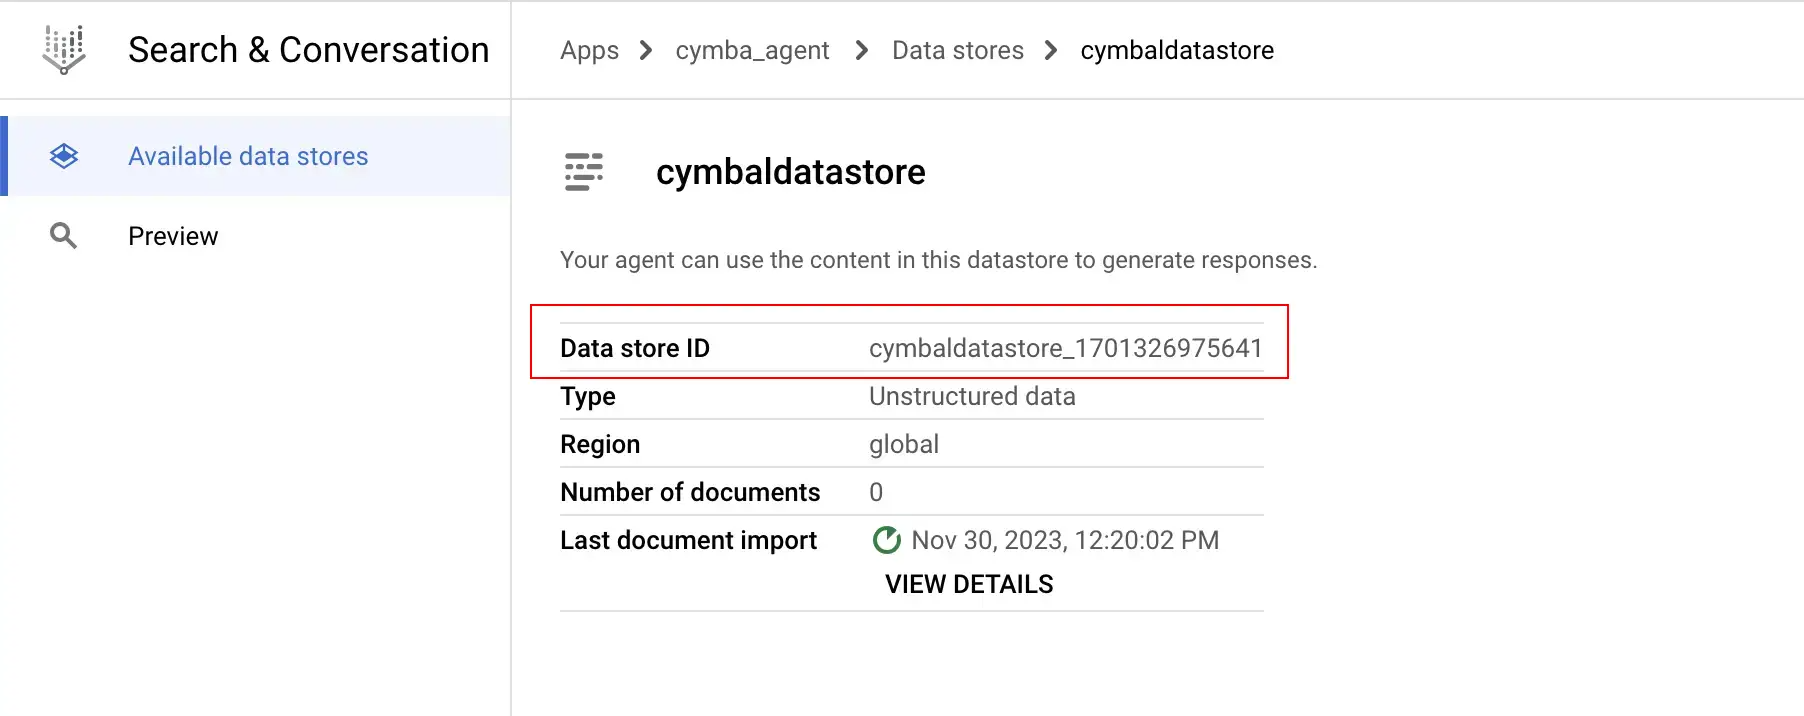

Data Store ID

In [3]:
PROJECT = !gcloud config get-value project
project_id  = PROJECT[0]
location = "global"  # Options: "global", "us", "eu"
datastore_id = "cymbaldatastore_1725625414302"

In [10]:
docs = list_documents(project_id, location, datastore_id)

if len(docs) == 0:
    print(PENDING_MESSAGE)
else:
    SUCCESS_MESSAGE = f"""
  Success! 🎉\n
  Your indexing is complete.\n
  Your index contains {len(docs)} documents.
  """
    print(SUCCESS_MESSAGE)


  Success! 🎉

  Your indexing is complete.

  Your index contains 79 documents.
  


In [11]:
docs = list_documents(project_id, location, datastore_id)
docs[0]

name: "projects/756398900932/locations/global/collections/default_collection/dataStores/cymbaldatastore_1725625414302/branches/0/documents/01c3140622cfed9a86572e550ed049a0"
id: "01c3140622cfed9a86572e550ed049a0"
schema_id: "default_schema"
struct_data {
}
parent_document_id: "01c3140622cfed9a86572e550ed049a0"
content {
  mime_type: "text/html"
  uri: "gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/testing.html"
}

In [12]:
document_id = "placeholder_document_id"
search_doc_id(document_id, docs=docs)

Document not found for provided Doc ID: `placeholder_document_id`


In [13]:
urls = list_indexed_urls(docs=docs)
urls[0]

'gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/testing.html'

In [14]:
search_url(urls, "gs://cloud-samples-data/dialogflow-cx/arc-lifeblood")

gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/testing.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/strategy.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/making-blood-components.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/making-your-donation.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/products.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/high-ferritin.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/forms.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/blood-for-transfusion.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/how-you-can-give-life.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/transplantation-immunogenetics-services.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/blood.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/prepare-and-aftercare.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/our-strategy.html
gs://cloud-samples-data/dialogflow-cx/arc-l

In [15]:
search_url(urls, "dialogflow-cx")

gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/testing.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/strategy.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/making-blood-components.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/making-your-donation.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/products.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/high-ferritin.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/forms.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/blood-for-transfusion.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/how-you-can-give-life.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/transplantation-immunogenetics-services.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/blood.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/prepare-and-aftercare.html
gs://cloud-samples-data/dialogflow-cx/arc-lifeblood/our-strategy.html
gs://cloud-samples-data/dialogflow-cx/arc-l